In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [3]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [4]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [5]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    """ print("y-shape %i" %y.shape)
    print("tx-shape %i" %tx.shape[0])
    print("w-shape: %i" %w.shape) """

    N = y.shape[0]
    e = y - tx @ w
    return 1/(2*N) * np.sum(np.square(e))


In [6]:
MSE = compute_loss(y, tx, np.array([1,2]))
print("MSE: %f" %MSE)

MSE: 2694.483366


In [7]:
a = np.array([1,2,4])
b = np.array([1,2,3])
print(a*b)

[ 1  4 12]


# 2. Grid Search

Fill in the function `grid_search()` below:

In [8]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """
    num_grid_pts_w0 = grid_w0.shape[0]
    num_grid_pts_w1 = grid_w1.shape[0]

    losses = np.empty(shape = (num_grid_pts_w0, num_grid_pts_w1))
    for i,w0 in enumerate(grid_w0):
        for j,w1 in enumerate(grid_w1):
            losses[i,j] = compute_loss(y, tx, np.array([w0, w1]))

    #losses = np.zeros((len(grid_w0), len(grid_w1)))
    
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=42.42448314678248, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.016 seconds


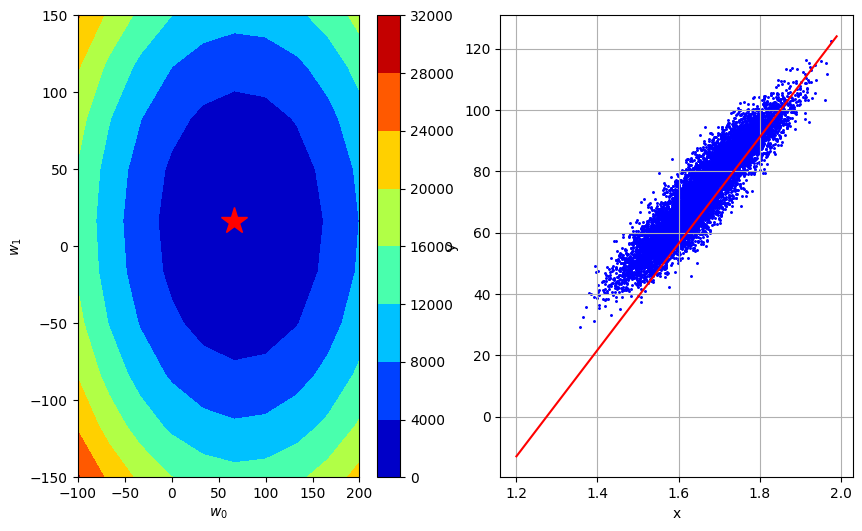

In [9]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [10]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute gradient vector
    # ***************************************************

    N = y.shape[0]
    e = y - tx @ w
    print(e.shape)
    print(tx.shape)
    return -1/N * (np.transpose(tx) @ e)

In [11]:
#y = np.array([1,2])
#tx = np.array([[1,3], [1,5]])
#w = np.array([1,1])

#print(compute_gradient(y,tx,w))
print("Gradient for [100, 20]: " + str(compute_gradient(y,tx,np.array([100, 20]))))
print("Gradient for [50, 10]: " + str(compute_gradient(y,tx,np.array([50, 10]))))

(10000,)
(10000, 2)
Gradient for [100, 20]: [26.706078    6.52028757]
(10000,)
(10000, 2)
Gradient for [50, 10]: [-23.293922    -3.47971243]
(10000,)
(10000, 2)
Gradient for [50, 10]: [-73.293922   -13.47971243]


Please fill in the functions `gradient_descent` below:

In [12]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute gradient and loss
        # ***************************************************
        loss = compute_loss(y,tx,w)
        grad = compute_gradient(y,tx,w)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by gradient
        # ***************************************************
        w = ws[n_iter] - gamma * grad

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [21]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

(10000,)
(10000, 2)
GD iter. 0/49: loss=2792.2367127591674, w0=21.98817660063158, w1=4.043913730496721
(10000,)
(10000, 2)
GD iter. 1/49: loss=1376.0427920650936, w0=37.379900221073726, w1=6.874653341844387
(10000,)
(10000, 2)
GD iter. 2/49: loss=682.1077709249969, w0=48.15410675538314, w1=8.85617106978777
(10000,)
(10000, 2)
GD iter. 3/49: loss=342.07961056635213, w0=55.69605132939975, w1=10.24323347934813
(10000,)
(10000, 2)
GD iter. 4/49: loss=175.4658119906157, w0=60.9754125312114, w1=11.214177166040404
(10000,)
(10000, 2)
GD iter. 5/49: loss=93.8250506885045, w0=64.67096537247953, w1=11.893837746724994
(10000,)
(10000, 2)
GD iter. 6/49: loss=53.821077650470265, w0=67.25785236136723, w1=12.36960015320421
(10000,)
(10000, 2)
GD iter. 7/49: loss=34.21913086183342, w0=69.06867325358863, w1=12.702633837739661
(10000,)
(10000, 2)
GD iter. 8/49: loss=24.61417693540132, w0=70.3362478781436, w1=12.935757416914475
(10000,)
(10000, 2)
GD iter. 9/49: loss=19.907749511449644, w0=71.22355011533

In [14]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [15]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from just few examples n and their corresponding y_n labels.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient computation. It's the same as the usual gradient.
    # ***************************************************
    raise NotImplementedError


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic gradient descent.
        # ***************************************************
        raise NotImplementedError

        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [16]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

NotImplementedError: 

In [ ]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

# 5. Effect of Outliers and MAE Cost Function

In [ ]:
import datetime
from helpers import *

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
# ***************************************************
raise NotImplementedError

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [ ]:
y.shape, tx.shape

In [ ]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
#       and the model fit
# ***************************************************
raise NotImplementedError


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 6. Subgradient descent

In [ ]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute subgradient gradient vector for MAE
    # ***************************************************
    raise NotImplementedError

In [ ]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute subgradient and loss
        # ***************************************************
        raise NotImplementedError
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by subgradient
        # ***************************************************
        raise NotImplementedError

        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [ ]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [ ]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic SubGradient Descent algorithm (SubSGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic subgradient descent.
        # ***************************************************
        raise NotImplementedError

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [ ]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))